#### 各パッケージのインストール，データ，hyperparametersの読み込み

In [1]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 2.86 µs


In [2]:
# CSVファイルにデータを保存
filename_with_force = 'OLD_rossler_data_with_shifted_forceArandom.csv'

# CSVファイルを読み込む
data_loaded_with_force = pd.read_csv(filename_with_force)

# CSVから値を抽出してNumpy配列に格納
X = data_loaded_with_force[['x', 'y', 'P_shifted']].values

print(X)


[[ 1.          1.         -2.        ]
 [ 0.61475268  1.10158579 -1.99000754]
 [ 0.25345477  1.16757742 -1.96012999]
 ...
 [-3.11491902  7.49294193  1.11992009]
 [-3.75393691  7.29748651  0.94889025]
 [-4.38739434  7.03376553  0.76837866]]


### 7. Generative Modelのうち，外力のデータのみ実データで更新し続ける．

期待としては，X, Yの精度も上がるということである．

In [3]:
n,m = X.shape

from reservoirpy.datasets import to_forecasting

train_len = 10000
test_len = 10000


In [4]:
def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):
    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations) + seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    # `warming_inputs`のサイズを検証して調整します。
    if warming_inputs is not None and len(warming_inputs) > seed_timesteps:
        # `seed_timesteps`に合わせてサイズを調整
        warming_inputs = warming_inputs[:seed_timesteps]
        plt.plot(warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations) + seed_timesteps, np.abs(X_t - X_gen), label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup period")

    plt.legend()
    plt.show()


In [5]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
    readout = Ridge(ridge=ridge)

    return reservoir >> readout


In [6]:
N = 10000
iss = 0.10294596097284181
lr = 0.6209000825565029
ridge =  0.0014880671478487075
seed = 5555
sr = 0.40757822086251727
forecast = 1
train_len = 10000
seed_timesteps = 5000
nb_generations = 2000


In [7]:
esn = reset_esn()

x, y = to_forecasting(X, forecast=1)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:], y[train_len:]

esn = esn.fit(X_train, y_train)


In [8]:
X_test.shape


(15099, 3)

In [9]:
warming_inputs = X_test[:seed_timesteps]

warming_out = esn.run(warming_inputs, reset=True)  # warmup
print(f"{warming_out[-1]}:warming_out[-1]")
print(f"{X_test[seed_timesteps]}:X_test[seed_timesteps]")
#warming_outはX_test[seed_timesteps]を近似する．


[-0.85186951 -4.97905541 -1.95761653]:warming_out[-1]
[-0.8543879  -4.97931763 -1.95561434]:X_test[seed_timesteps]


In [10]:
X_gen = np.zeros((nb_generations, m))
y = warming_out[-1] 
print(y.shape) 
y = y.reshape(1, -1) 
print(y.shape) #配列の形式は(n, m)の二次元配列にする必要があるので調整した


(3,)
(1, 3)


In [11]:
for t in range(nb_generations):  
    y[:, 2:3] = X_test[seed_timesteps+t, 2:3] #外力にあたる[:, 2:3]に実測値を代入する．
    y = esn(y) #ESNで1回=0.1ステップ先を予測する．
    X_gen[t, :] = y #配列に記録していく
            
X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]


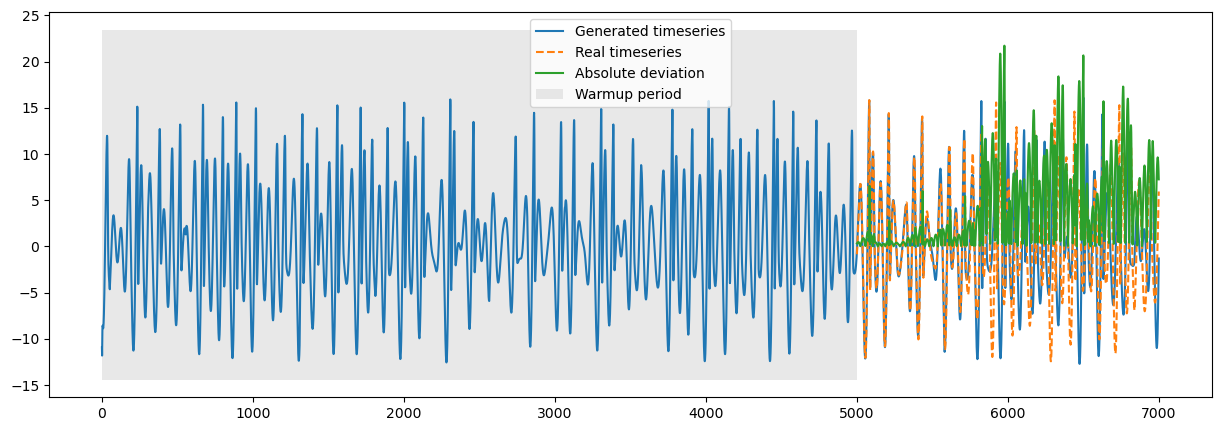

In [12]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)


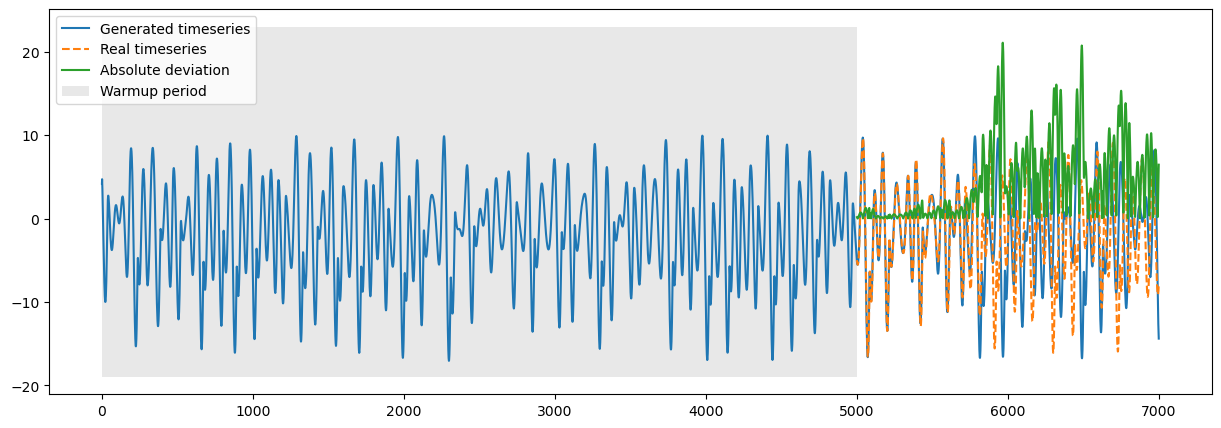

In [13]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)


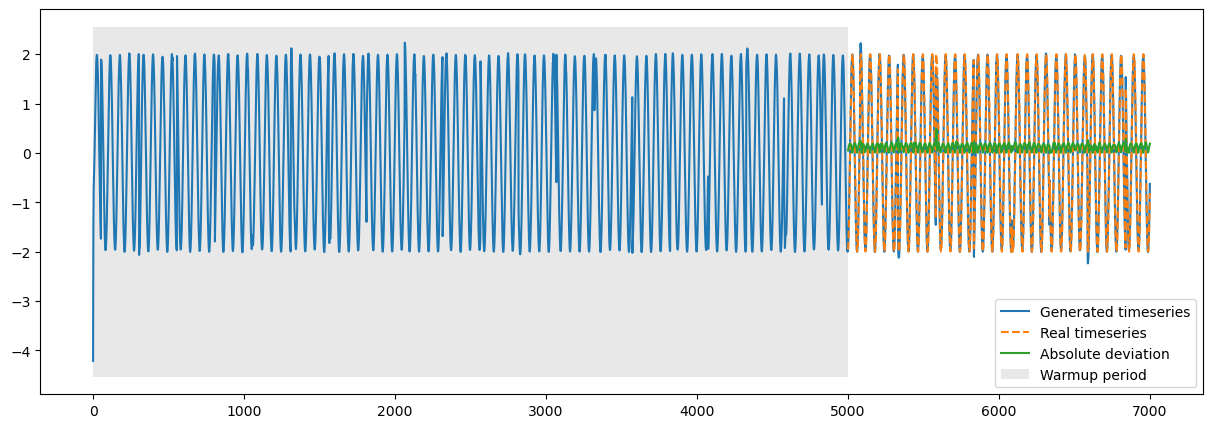

In [14]:
plot_generation(X_gen[:, 2:3], X_t[:, 2:3], nb_generations, warming_out=warming_out[:, 2:3],
                warming_inputs=warming_inputs[:, 2:3], seed_timesteps=seed_timesteps)


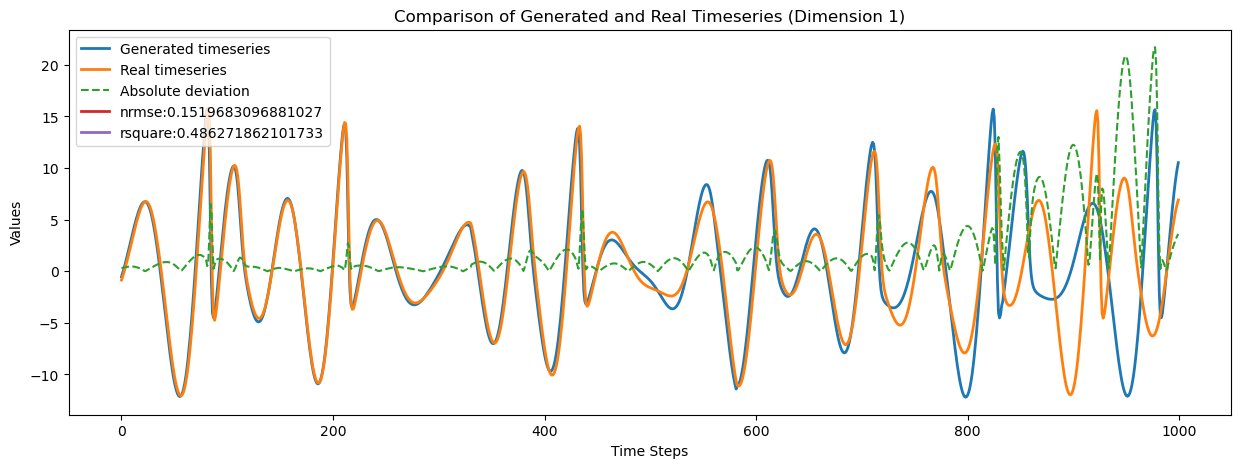

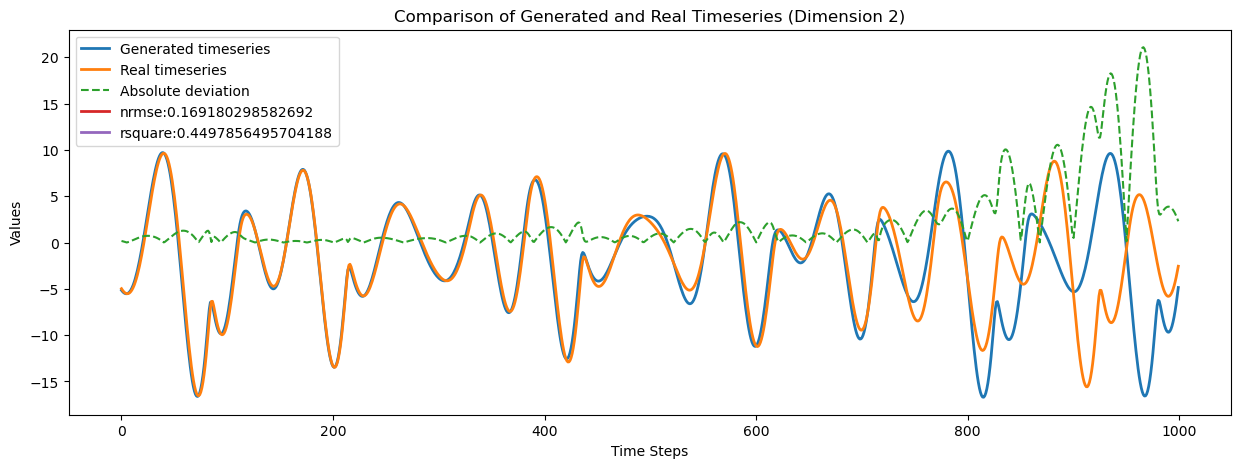

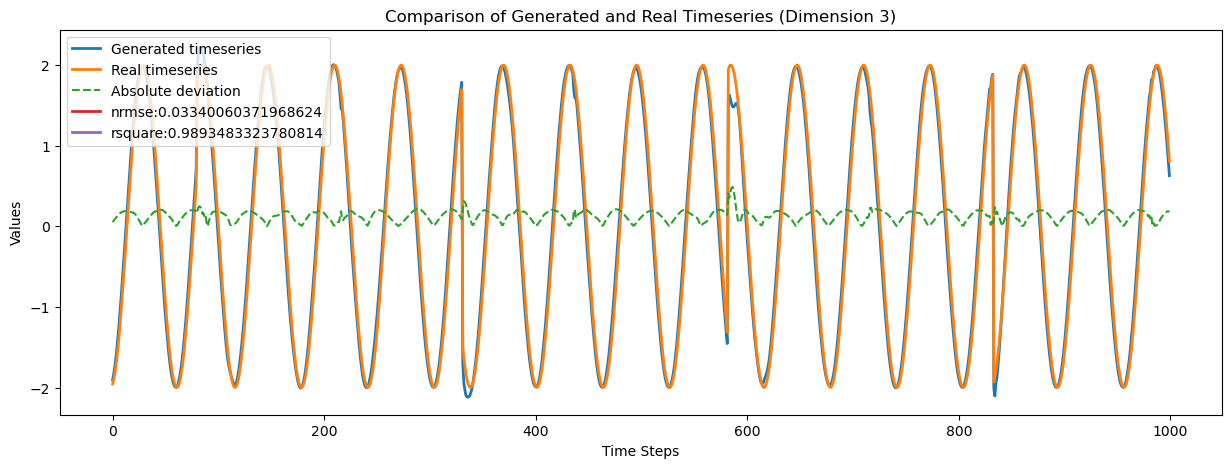

In [15]:
# 時系列データの比較を行う関数
def compare_timeseries_multidimensional(X_gen, X_t):
    num_dimensions = X_gen.shape[1]  # 次元数を取得
    for dim in range(num_dimensions):
        plt.figure(figsize=(15, 5))
        plt.plot(X_gen[:, dim][:1000], label="Generated timeseries", linewidth=2)
        plt.plot(X_t[:, dim][:1000], label="Real timeseries", linewidth=2)
        plt.plot(np.abs(X_t[:, dim][:1000] - X_gen[:, dim][:1000]), label="Absolute deviation", linestyle='--')
        plt.plot(nrmse(X_gen[:, dim][:1000], X_t[:, dim][:1000]), label=f"nrmse:{nrmse(X_gen[:, dim][:1000], X_t[:, dim][:1000])}", linewidth=2)
        plt.plot(rsquare(X_gen[:, dim][:1000], X_t[:, dim][:1000]), label=f"rsquare:{rsquare(X_gen[:, dim][:1000], X_t[:, dim][:1000])}", linewidth=2)

        plt.title(f'Comparison of Generated and Real Timeseries (Dimension {dim+1})')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.legend()        
        plt.show()

# 使用例:
compare_timeseries_multidimensional(X_gen, X_t)


3~4周期先までの予測．

### 外力の形が異なるものに対して予測が可能なのかを調べよう

In [16]:
# CSVファイルにデータを保存
filename_with_force = 'rossler_data_with_shifted_forceA1.0.csv'

# CSVファイルを読み込む
data_loaded_with_force = pd.read_csv(filename_with_force)

# CSVから値を抽出してNumpy配列に格納
X_alt = data_loaded_with_force[['x', 'y', 'P_shifted']].values

print(X_alt)


[[ 1.          1.          0.        ]
 [ 0.81884635  1.11179778  0.09983738]
 [ 0.666639    1.20911264  0.19867714]
 ...
 [-6.49597703 -0.37221429  0.32644321]
 [-6.39958865 -1.03151971  0.23044426]
 [-6.24691701 -1.69157376  0.13214259]]


In [17]:
n,m = X_alt.shape

from reservoirpy.datasets import to_forecasting

train_len = 10000
test_len = 10000


In [18]:
#esn = reset_esn() Let ESN learn sequentially with different external drivings. 

x, y = to_forecasting(X_alt, forecast=1)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:], y[train_len:]

esn = esn.fit(X_train, y_train)


In [19]:
warming_inputs = X_test[:seed_timesteps]

warming_out = esn.run(warming_inputs, reset=True)  # warmup
print(f"{warming_out[-1]}:warming_out[-1]")
print(f"{X_test[seed_timesteps]}:X_test[seed_timesteps]")
#warming_outはX_test[seed_timesteps]を近似する．


[-0.32672405 -1.55894513  0.51922509]:warming_out[-1]
[-0.32399145 -1.55949302  0.54327033]:X_test[seed_timesteps]


In [20]:
X_gen = np.zeros((nb_generations, m))
y = warming_out[-1] 
print(y.shape) 
y = y.reshape(1, -1) 
print(y.shape) #配列の形式は(n, m)の二次元配列にする必要があるので調整した


(3,)
(1, 3)


In [21]:
for t in range(nb_generations):  
    y[:, 2:3] = X_test[seed_timesteps+t, 2:3] #外力にあたる[:, 2:3]に実測値を代入する．
    y = esn(y) #ESNで1回=0.1ステップ先を予測する．
    X_gen[t, :] = y #配列に記録していく
            
X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]


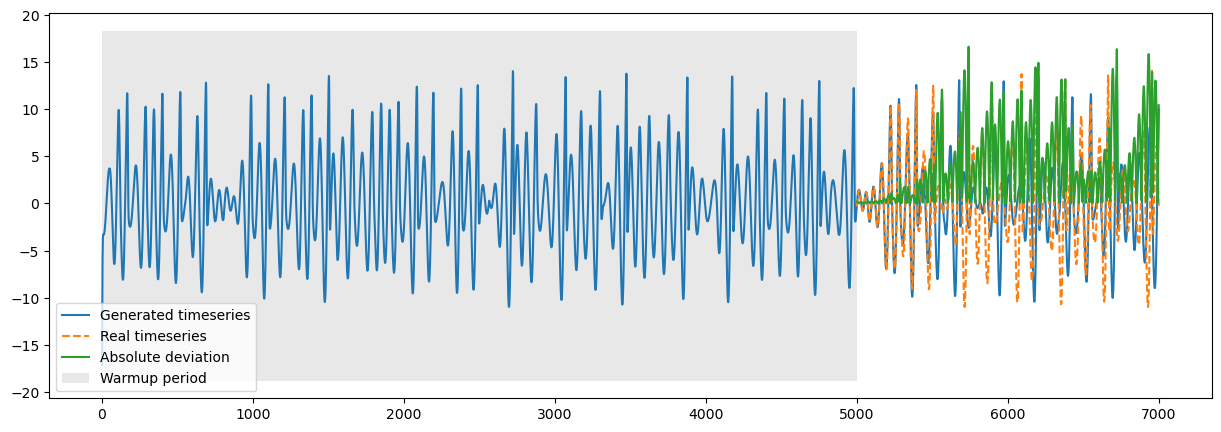

In [22]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)


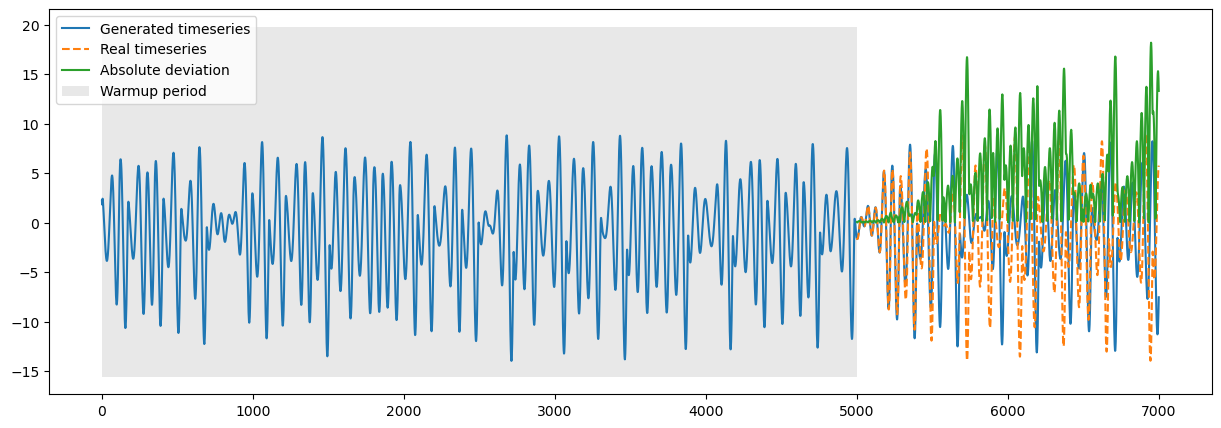

In [23]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)


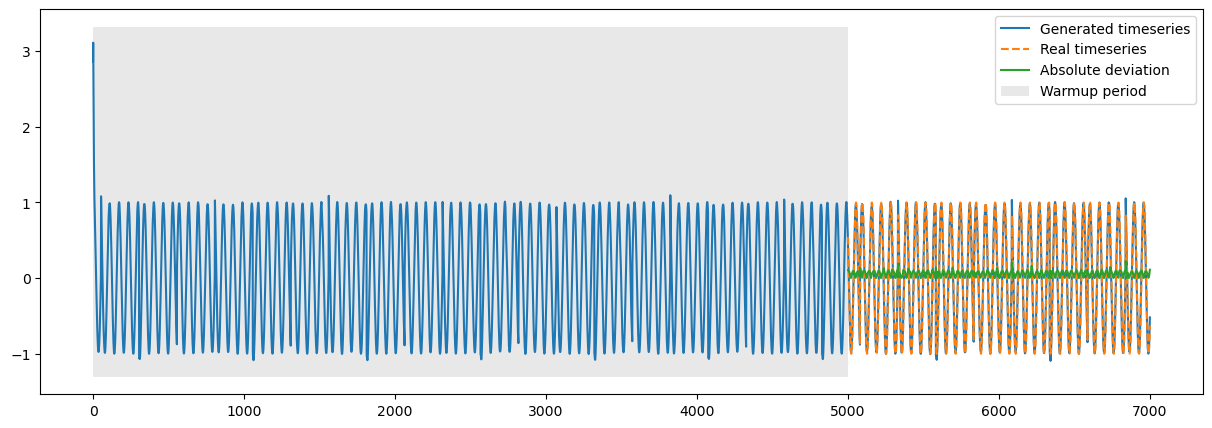

In [24]:
plot_generation(X_gen[:, 2:3], X_t[:, 2:3], nb_generations, warming_out=warming_out[:, 2:3],
                warming_inputs=warming_inputs[:, 2:3], seed_timesteps=seed_timesteps)


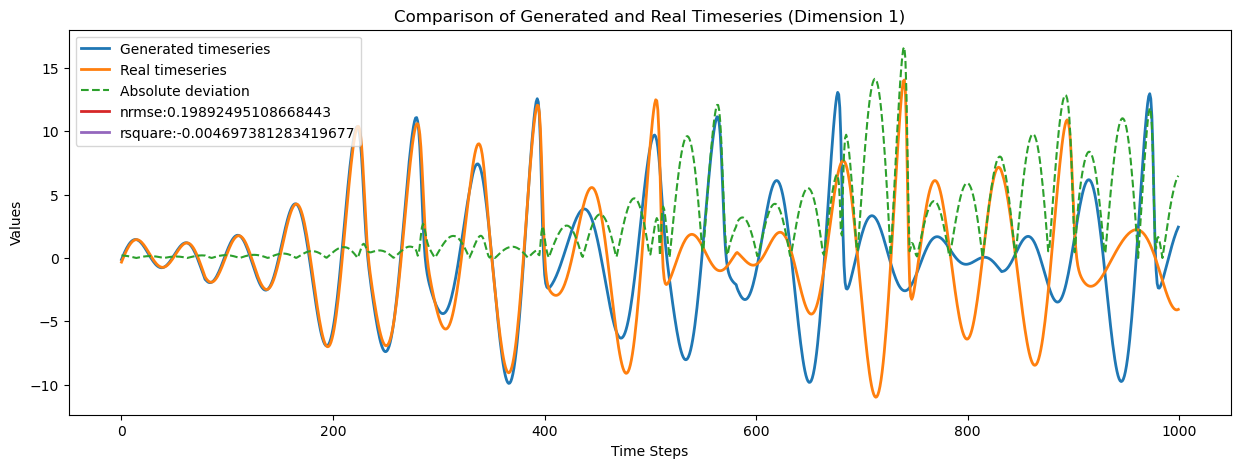

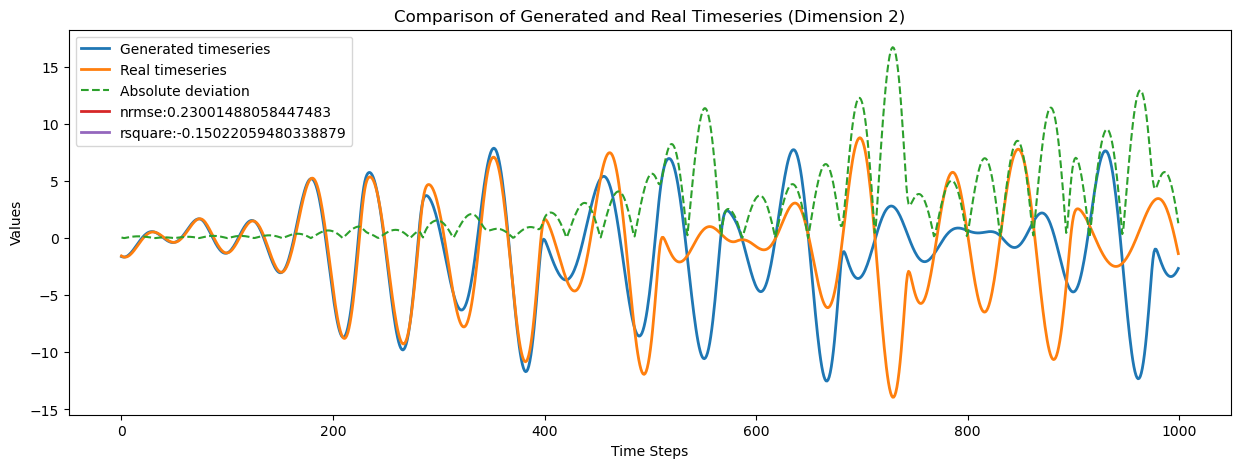

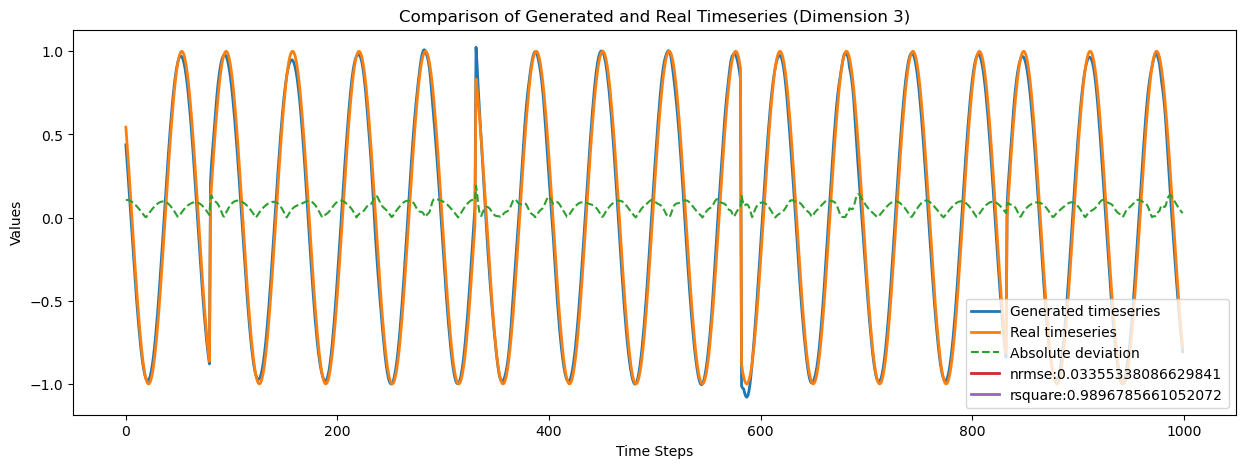

In [25]:
compare_timeseries_multidimensional(X_gen, X_t)
